In [1]:
import math

import selenium.common.exceptions
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from timeit import default_timer as timer
from datetime import datetime
import numpy as np
import pandas as pd


def get_products_from_page(url, category, dr, products, waiting_time):
    start_time = timer()

    try:
        #use chromedriver  instead of Request to get our HTML page content
        dr.set_page_load_timeout(waiting_time)
        dr.get(url)
    except selenium.common.exceptions.TimeoutException:
        return -1

    soup = BeautifulSoup(dr.page_source, 'html.parser')

    # This is the important part that changes from one website to another (same structure, just pull out the data from different tags)
    all_products = [article for article in soup.find_all(
        'article', {'class': 'item'})]

    for prod in all_products:
        name = prod.find_all('h2', {'class': 'item__title'})[0].find('a')['title']
        link = 'https://www.rueducommerce.fr' + prod.find_all('h2', {'class': 'item__title'})[0].find('a')['href']

        if(len(prod.find_all('span', {'class': 'item__price--old-box'})) > 0 ) :
            price_promo = prod.find_all('span', {'class': 'item__price--new-box'})
            price_old = prod.find_all('span', {'class': 'item__price--old-box'})
        else :
            price_promo = None
            price_old = prod.find_all('span', {'class': 'item__price--new-box'})

        if (price_promo and price_old ):
            price_promo = price_promo[0].find('span').string
            price_old = price_old[0].find('span').string

        else:
            price_old = price_old[0].find('span').string

        description = prod.find_all('p', {'class': 'item__caracs'})[0].find('a').string

        # Here ends the important part

        row = {
            'website': 'www.rueducommerce.fr',
            'Brand': category,
            'time': datetime.now(),
            'name': name,
            'description': description,
            'price_promo': price_promo,
            'price_old' :price_old,
            'link': link,
        }

        products.append(row)

    end_time = timer()
    print('Treatment time: ' + str(np.round(end_time - start_time, 2)) + 's. ', end='')

    return products


def get_all_products(waiting_time, nb_retries):
    option = webdriver.ChromeOptions()
    option.add_argument('headless')
    option.add_experimental_option("excludeSwitches", ["enable-automation"])
    option.add_experimental_option('excludeSwitches', ['enable-logging'])
    option.add_experimental_option('useAutomationExtension', False)

    dr = webdriver.Chrome("C:/Users/asus/Desktop/chromedriver.exe")

    products = []


    categories = []
    urls = []

    with open('urls.txt', 'r') as f:
        for line in f:
            strip_lines = line.strip()
            cat, url = strip_lines.split(', ')
            categories.append(cat)
            urls.append(url)

    retries = 0

    for cat, url in zip(categories, urls):
        print('Started fetching ' + url + '...', end='\n\n')

        while get_products_from_page(url, cat, dr, products, waiting_time) == -1 and retries < nb_retries:
            print('ERROR: Could not connect to web page within time limit (' + str(waiting_time) + ' s).')
            print('Restarted fetching ' + url + '...', end=' ')
            retries += 1

        else:
            if retries >= nb_retries:
                print("Permitted number of retries reached. Fetched " + str(len(products)) + " products.")
            else:
                print("Finished. Fetched all requested products.")

    dr.quit()
    return products



In [2]:
waiting_time = 10
nb_retries = 10

products = get_all_products(waiting_time, nb_retries)

print(len(products))


<ipython-input-1-2b2c04d259bb>:77: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  dr = webdriver.Chrome("C:/Users/asus/Desktop/chromedriver.exe")


Started fetching https://www.rueducommerce.fr/rayon/ordinateurs-64/ordinateur-portable-657/msi...

Treatment time: 6.35s. Finished. Fetched all requested products.
Started fetching https://www.rueducommerce.fr/rayon/ordinateurs-64/ordinateur-portable-657/hp...

Treatment time: 2.08s. Finished. Fetched all requested products.
Started fetching https://www.rueducommerce.fr/rayon/ordinateurs-64/ordinateur-portable-657/asus...

Treatment time: 1.46s. Finished. Fetched all requested products.
180


In [263]:
df=pd.DataFrame(products)

In [264]:
df

,website,Brand,time,name,description,price_promo,price_old,link
0,www.rueducommerce.fr,MSI,2022-06-02 18:43:30.281834,Msi - Creator Z16 A11UET-276FR,16' Tactile 120 Hz QHD+ - Nvidia RTX 3060 MAX-...,None,"2 399,00",https://www.rueducommerce.fr/p-creator-z16-a11...
1,www.rueducommerce.fr,MSI,2022-06-02 18:43:30.281834,Msi - Raider GE66 12UH-222FR,"15.6"" UHD 120Hz - RTX 3080 GDDR6 8Go - intel C...",None,"3 499,99",https://www.rueducommerce.fr/p-raider-ge66-12u...
2,www.rueducommerce.fr,MSI,2022-06-02 18:43:30.281834,Msi - Raider GE66 12UGS-088FR,"15.6"" FHD 360Hz - RTX 3070 Ti GDDR6 8Go - inte...","3 499,95","3 600,98",https://www.rueducommerce.fr/p-raider-ge66-12u...
3,www.rueducommerce.fr,MSI,2022-06-02 18:43:30.281834,Msi - Raider GE66 12UHS-219FR,"15.6"" UHD 120Hz - RTX 3080 Ti GDDR6 16Go - int...",None,"3 999,99",https://www.rueducommerce.fr/p-raider-ge66-12u...
4,www.rueducommerce.fr,MSI,2022-06-02 18:43:30.297465,Msi - Raider GE76 12UHS-229FR,"17.3"" UHD 120Hz - RTX 3080 Ti GDDR6 16Go - int...",None,"5 099,99",https://www.rueducommerce.fr/p-raider-ge76-12u...
...,...,...,...,...,...,...,...,...
175,www.rueducommerce.fr,ASUS,2022-06-02 18:43:33.962830,Asus - Vivobook R515EA - Argent + Sacoche + So...,"15"" FHD - Intel Core i5-1135G7 - RAM 8 Go - S...","649,99","679,99",https://www.rueducommerce.fr/p-vivobook-r515ea...
176,www.rueducommerce.fr,ASUS,2022-06-02 18:43:33.962830,Asus - ZenBook S13 - UX392FN-AB009T - Bleu Galaxy,"13,9'' Full HD - Intel Core i7-8565U - SSD 1 T...",None,"1 769,99",https://www.rueducommerce.fr/produit/asus-zenb...
177,www.rueducommerce.fr,ASUS,2022-06-02 18:43:33.962830,Asus - Vivobook R415EA-EK1154W - Argent Transp...,"14"" FHD 220 Nits - Intel Core i3-1115G4 - RAM ...","569,99","599,99",https://www.rueducommerce.fr/p-vivobook-r415ea...
178,www.rueducommerce.fr,ASUS,2022-06-02 18:43:33.962830,"Asus - VivoBook 15"" S533UA-BQ020T - Argent","15"" FHD - AMD Ryzen 7 5700U - RAM 8 Go - SSD 5...",None,"749,99",https://www.rueducommerce.fr/p-vivobook-15-s53...


In [47]:
# for ind, row in df.iterrows():
#     df.at[ind,"color"] = row["name"].rsplit("-",1)[-1]
#     df.at[ind,"brand"] = row["name"].split("-",1)[0]

# Data Processing


In [48]:
# df['price_old'].apply(lambda x : float(".".join(x.split(","))))
for ind, row in df.iterrows():
    prix1=row["price_old"].split(",")
    prix1[0]="".join(prix1[0].split())
    prix1=float(".".join(prix1))
    df.at[ind,"price_old"] = prix1
    if(row["price_promo"]  ) :
     prix2=row["price_promo"].split(",")
     prix2[0]="".join(prix2[0].split())
     prix2=float(".".join(prix2))
     df.at[ind,"price_promo"] = prix2

In [49]:
df

,website,Brand,time,name,description,price_promo,price_old,link
0,www.rueducommerce.fr,MSI,2022-06-02 18:43:30.281834,Msi - Creator Z16 A11UET-276FR,16' Tactile 120 Hz QHD+ - Nvidia RTX 3060 MAX-...,None,2399.0,https://www.rueducommerce.fr/p-creator-z16-a11...
1,www.rueducommerce.fr,MSI,2022-06-02 18:43:30.281834,Msi - Raider GE66 12UH-222FR,"15.6"" UHD 120Hz - RTX 3080 GDDR6 8Go - intel C...",None,3499.99,https://www.rueducommerce.fr/p-raider-ge66-12u...
2,www.rueducommerce.fr,MSI,2022-06-02 18:43:30.281834,Msi - Raider GE66 12UGS-088FR,"15.6"" FHD 360Hz - RTX 3070 Ti GDDR6 8Go - inte...",3499.95,3600.98,https://www.rueducommerce.fr/p-raider-ge66-12u...
3,www.rueducommerce.fr,MSI,2022-06-02 18:43:30.281834,Msi - Raider GE66 12UHS-219FR,"15.6"" UHD 120Hz - RTX 3080 Ti GDDR6 16Go - int...",None,3999.99,https://www.rueducommerce.fr/p-raider-ge66-12u...
4,www.rueducommerce.fr,MSI,2022-06-02 18:43:30.297465,Msi - Raider GE76 12UHS-229FR,"17.3"" UHD 120Hz - RTX 3080 Ti GDDR6 16Go - int...",None,5099.99,https://www.rueducommerce.fr/p-raider-ge76-12u...
...,...,...,...,...,...,...,...,...
175,www.rueducommerce.fr,ASUS,2022-06-02 18:43:33.962830,Asus - Vivobook R515EA - Argent + Sacoche + So...,"15"" FHD - Intel Core i5-1135G7 - RAM 8 Go - S...",649.99,679.99,https://www.rueducommerce.fr/p-vivobook-r515ea...
176,www.rueducommerce.fr,ASUS,2022-06-02 18:43:33.962830,Asus - ZenBook S13 - UX392FN-AB009T - Bleu Galaxy,"13,9'' Full HD - Intel Core i7-8565U - SSD 1 T...",None,1769.99,https://www.rueducommerce.fr/produit/asus-zenb...
177,www.rueducommerce.fr,ASUS,2022-06-02 18:43:33.962830,Asus - Vivobook R415EA-EK1154W - Argent Transp...,"14"" FHD 220 Nits - Intel Core i3-1115G4 - RAM ...",569.99,599.99,https://www.rueducommerce.fr/p-vivobook-r415ea...
178,www.rueducommerce.fr,ASUS,2022-06-02 18:43:33.962830,"Asus - VivoBook 15"" S533UA-BQ020T - Argent","15"" FHD - AMD Ryzen 7 5700U - RAM 8 Go - SSD 5...",None,749.99,https://www.rueducommerce.fr/p-vivobook-15-s53...


In [50]:
for ind , row in df.iterrows():
    if any(el in row.description  for el in ['Tactile','tactile'] ) :
        df.at[ind, "Tactile"] = "OUI"
    else :
        df.at[ind, "Tactile"] = "NON"


In [51]:
for ind , row in df.iterrows() :
    for car in row["description"].split("-") :
      if any(el in car for el in ['14"','15.6"',"15.6","15,6","15,6'",'15,6"',"13.3","144 Hz",'17,3"','17.3"','17"',"16,1",'15"','16"','13"',"14'","15.6'","15'","16'","13'",'OLED','4k','3K', 'FHD OLED',"IPS",'Tactile'] ):
         df.at[ind,'Ecran'] = car
      elif any(el in car for el in ['Intel Core','i5','i3','i7','I5','I7','I3','i9','I9','Ryzen','AMD Ryzen','PEN','Pentium','PENTIUM',"Athlon","Celeron"] ):
          df.at[ind,'Processeur'] = car
      elif any(el in car for el in ['ssd','SSD','HDD','hdd','512','Nvme','PCIe','1To','256','128'] ):
          df.at[ind,'Stockage'] = car
      elif any(el in car for el in ['ram','Ram','RAM','DDR4','DDR3','mémoire'] ):
          df.at[ind,'RAM'] = car
      elif any(el in car for el in ['Nvidia','GeForce','Radeon','Intel Iris','AMD Radeon','RTX','GTX','Ti','Graphics'] ):
          df.at[ind,'Carte Graphique'] = car
      elif any(el in car for el in ['Windows','Linux','windows','Ubuntu'] ):
          df.at[ind,'OS'] = car






In [52]:
df= df.drop(columns=["website","time","link"])

In [53]:
df=df.astype(str)

In [54]:
df.Ecran  = df.Ecran .apply(lambda x : x.replace(',', '.')) # virgule to point

In [55]:
df

,Brand,name,description,price_promo,price_old,Tactile,Ecran,Carte Graphique,Processeur,RAM,Stockage,OS
0,MSI,Msi - Creator Z16 A11UET-276FR,16' Tactile 120 Hz QHD+ - Nvidia RTX 3060 MAX-...,None,2399.0,OUI,16' Tactile 120 Hz QHD+,Nvidia RTX 3060 MAX,Intel Core i7,RAM 16 Go,SSD 512 Go,Windows 11
1,MSI,Msi - Raider GE66 12UH-222FR,"15.6"" UHD 120Hz - RTX 3080 GDDR6 8Go - intel C...",None,3499.99,NON,"15.6"" UHD 120Hz",RTX 3080 GDDR6 8Go,intel Core i7,RAM DDR5 32 Go,SSD 1 To,Windows 11
2,MSI,Msi - Raider GE66 12UGS-088FR,"15.6"" FHD 360Hz - RTX 3070 Ti GDDR6 8Go - inte...",3499.95,3600.98,NON,"15.6"" FHD 360Hz",RTX 3070 Ti GDDR6 8Go,intel Core i9,RAM DDR5 32 Go,SSD 2 To,Windows 11 Pro
3,MSI,Msi - Raider GE66 12UHS-219FR,"15.6"" UHD 120Hz - RTX 3080 Ti GDDR6 16Go - int...",None,3999.99,NON,"15.6"" UHD 120Hz",RTX 3080 Ti GDDR6 16Go,intel Core i7,RAM DDR5 32 Go,SSD 1 To,Windows 11
4,MSI,Msi - Raider GE76 12UHS-229FR,"17.3"" UHD 120Hz - RTX 3080 Ti GDDR6 16Go - int...",None,5099.99,NON,"17.3"" UHD 120Hz",RTX 3080 Ti GDDR6 16Go,intel Core i9,RAM DDR5 64 Go,SSD 2 To,Windows 11 Pro
...,...,...,...,...,...,...,...,...,...,...,...,...
175,ASUS,Asus - Vivobook R515EA - Argent + Sacoche + So...,"15"" FHD - Intel Core i5-1135G7 - RAM 8 Go - S...",649.99,679.99,NON,"15"" FHD",Intel Iris Xe Graphics,Intel Core i5,RAM 8 Go,SSD 256 Go,Windows 11
176,ASUS,Asus - ZenBook S13 - UX392FN-AB009T - Bleu Galaxy,"13,9'' Full HD - Intel Core i7-8565U - SSD 1 T...",None,1769.99,NON,nan,NVIDIA GeForce MX150 2 Go,Intel Core i7,RAM 16 Go,SSD 1 To,Windows 10
177,ASUS,Asus - Vivobook R415EA-EK1154W - Argent Transp...,"14"" FHD 220 Nits - Intel Core i3-1115G4 - RAM ...",569.99,599.99,NON,"14"" FHD 220 Nits",Intel® UHD Graphics,Intel Core i3,RAM 8 Go,SSD 512 Go,Windows 11
178,ASUS,"Asus - VivoBook 15"" S533UA-BQ020T - Argent","15"" FHD - AMD Ryzen 7 5700U - RAM 8 Go - SSD 5...",None,749.99,NON,"15"" FHD",AMD Radeon Graphics,AMD Ryzen 7 5700U,RAM 8 Go,SSD 512 Go,Windows 10


In [56]:
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False


In [57]:
import math
for ind , row in df.iterrows():
    for el in row.Ecran.split() :
        if any(car in el for car in ["'",'"','”']) :
            for specialChar in ["'",'"','”'] :
              el = el.replace(specialChar, '')
            if isfloat(el) :
             df.at[ind, "Ecran"] = float(el)
        elif isfloat(el) :
            df.at[ind, "Ecran"] = float(el)

# df.Ecran.apply( lambda x: x.split(" ")[0] )
# df.Ecran.apply(lambda x : float(x)/10 if (float(x) > 100) else x )

In [58]:
df

,Brand,name,description,price_promo,price_old,Tactile,Ecran,Carte Graphique,Processeur,RAM,Stockage,OS
0,MSI,Msi - Creator Z16 A11UET-276FR,16' Tactile 120 Hz QHD+ - Nvidia RTX 3060 MAX-...,None,2399.0,OUI,120.0,Nvidia RTX 3060 MAX,Intel Core i7,RAM 16 Go,SSD 512 Go,Windows 11
1,MSI,Msi - Raider GE66 12UH-222FR,"15.6"" UHD 120Hz - RTX 3080 GDDR6 8Go - intel C...",None,3499.99,NON,15.6,RTX 3080 GDDR6 8Go,intel Core i7,RAM DDR5 32 Go,SSD 1 To,Windows 11
2,MSI,Msi - Raider GE66 12UGS-088FR,"15.6"" FHD 360Hz - RTX 3070 Ti GDDR6 8Go - inte...",3499.95,3600.98,NON,15.6,RTX 3070 Ti GDDR6 8Go,intel Core i9,RAM DDR5 32 Go,SSD 2 To,Windows 11 Pro
3,MSI,Msi - Raider GE66 12UHS-219FR,"15.6"" UHD 120Hz - RTX 3080 Ti GDDR6 16Go - int...",None,3999.99,NON,15.6,RTX 3080 Ti GDDR6 16Go,intel Core i7,RAM DDR5 32 Go,SSD 1 To,Windows 11
4,MSI,Msi - Raider GE76 12UHS-229FR,"17.3"" UHD 120Hz - RTX 3080 Ti GDDR6 16Go - int...",None,5099.99,NON,17.3,RTX 3080 Ti GDDR6 16Go,intel Core i9,RAM DDR5 64 Go,SSD 2 To,Windows 11 Pro
...,...,...,...,...,...,...,...,...,...,...,...,...
175,ASUS,Asus - Vivobook R515EA - Argent + Sacoche + So...,"15"" FHD - Intel Core i5-1135G7 - RAM 8 Go - S...",649.99,679.99,NON,15.0,Intel Iris Xe Graphics,Intel Core i5,RAM 8 Go,SSD 256 Go,Windows 11
176,ASUS,Asus - ZenBook S13 - UX392FN-AB009T - Bleu Galaxy,"13,9'' Full HD - Intel Core i7-8565U - SSD 1 T...",None,1769.99,NON,NaN,NVIDIA GeForce MX150 2 Go,Intel Core i7,RAM 16 Go,SSD 1 To,Windows 10
177,ASUS,Asus - Vivobook R415EA-EK1154W - Argent Transp...,"14"" FHD 220 Nits - Intel Core i3-1115G4 - RAM ...",569.99,599.99,NON,220.0,Intel® UHD Graphics,Intel Core i3,RAM 8 Go,SSD 512 Go,Windows 11
178,ASUS,"Asus - VivoBook 15"" S533UA-BQ020T - Argent","15"" FHD - AMD Ryzen 7 5700U - RAM 8 Go - SSD 5...",None,749.99,NON,15.0,AMD Radeon Graphics,AMD Ryzen 7 5700U,RAM 8 Go,SSD 512 Go,Windows 10


In [59]:
import math
df.Ecran = df.Ecran.apply(lambda x : df.Ecran.mode()[0] if x >200 or math.isnan(x) else
                          x/10 if x> 100 else
                          x
               )

In [60]:
df["Carte Graphique"].unique()

array([' Nvidia RTX 3060 MAX', ' RTX 3080 GDDR6 8Go ',
       ' RTX 3070 Ti GDDR6 8Go ', ' RTX 3080 Ti GDDR6 16Go ',
       ' GTX 1650 Max Q GDDR6 ', ' Nvidia RTX 3070 ',
       ' Intel UHD Graphics ', ' GeForce RTX™ 3070 Max',
       ' NVIDIA GeForce RTX 3050 4 Go ', 'Nvidia RTX 3060 ',
       ' RTX 3070 GDDR6 8Go ', ' RTX 3060 GDDR6 6Go ',
       ' NVIDIA GeForce RTX 3080 Max', ' RTX 3050 Max',
       ' Nvidia GeForce GTX 1650 ', ' Nvidia GeForce RTX 3050 ', 'nan',
       ' UHD Graphics ', ' RTX 3070 Ti ', ' RTX 3050 GDDR6 ',
       ' Nvidia GTX 1660 Ti ', ' Nvidia GTX 1650 ti ',
       ' Nvidia GTX 1660 ', ' RTX 3070 Max', 'Nvidia RTX 3050 MAX',
       ' Nvidia RTX 3050 ', ' NVIDIA GeForce RTX 3060 6 Go ',
       ' AMD Radeon™ RX 6700M', ' Nvidia RTX 3060 6 Go ',
       ' RTX 3070 Ti Max', ' RTX 3080 ', ' RTX 3060 Max',
       ' Nvidia RTX 3060 ', ' Nvidia GTX 1650 Max Q ',
       ' Iris Xe Graphics ', ' NVIDIA GeForce RTX 3080 16 Go ',
       ' Nvidia RTX 3080 ', ' NVIDIA GeForce R

# Rule Based Data featuring

In [61]:
for ind , row in df.iterrows():
    if any(el in ["NVIDIA","Nvidia","RTX","GTX"] for el in row["Carte Graphique"].split(" ")) :
        df.at[ind,"GPU brand"] = "NVIDIA"
    elif any(el in ["AMD","Amd","Radeon","Athlon"] for el in row["Carte Graphique"].split(" ")):
        df.at[ind,"GPU brand"] = "AMD"
    elif any(el in ["Intel","INTEL","Graphics"] for el in row["Carte Graphique"].split(" ")):
        df.at[ind,"GPU brand"] = "Intel"

In [62]:
for ind , row in df.iterrows():
    if any(el in ["i5","I5"] for el in row["Processeur"].split(" ")) :
        df.at[ind,"Processeur"] = "i5"
    elif any(el in ["i3","I3"] for el in row["Processeur"].split(" ")):
        df.at[ind,"Processeur"] = "i3"
    elif any(el in ["i7","I7"] for el in row["Processeur"].split(" ")):
        df.at[ind,"Processeur"] = "i7"
    elif any(el in ["i9","I9"] for el in row["Processeur"].split(" ")):
        df.at[ind,"Processeur"] = "i9"
    elif "Ryzen 5" in row["Processeur"]:
        df.at[ind,"Processeur"] = "Ryzen 5"
    elif "Ryzen 7" in row["Processeur"]:
        df.at[ind,"Processeur"] = "Ryzen 7"
    elif "Ryzen 9" in row["Processeur"]:
        df.at[ind,"Processeur"] = "Ryzen 9"
    elif "Ryzen 3" in row["Processeur"]:
        df.at[ind,"Processeur"] = "Ryzen 3"
    elif any(el in ["Celeron","CELERON"] for el in row["Processeur"].split(" ")):
        df.at[ind,"Processeur"] = "Celeron"
    elif any(el in ["Athlon","ATHLON"] for el in row["Processeur"].split(" ")):
        df.at[ind,"Processeur"] = "Athlon"
    elif any(el in ["PENTIUM","Pentium"] for el in row["Processeur"].split(" ")):
        df.at[ind,"Processeur"] = "Athlon"

In [63]:
df.OS= df.OS.apply(lambda x : "Windows 10"  if ("Windows 10" in x)
                            else ( "Windows 11" if "Windows 11" in x
                                   else None  )
)

In [75]:
lst = ["RAM","GO","Go","GB","DDR4","DDR5","DDR3"]

for ind , row in df.iterrows() :
    if any(el in row.RAM for el in lst) :
        for el in lst :
            df.at[ind, "RAM"] = df.at[ind,"RAM"].replace(el,"")

    df.at[ind,"RAM"] = df.at[ind,"RAM"].split()[0]

rm = ['4','6','8','12','16','32','64']
df.RAM = df.RAM.apply(lambda x : df.RAM.mode()[0] if x not in rm else
                         x )

In [77]:
df

,Brand,name,description,price_promo,price_old,Tactile,Ecran,Carte Graphique,Processeur,RAM,Stockage,OS,GPU brand
0,MSI,Msi - Creator Z16 A11UET-276FR,16' Tactile 120 Hz QHD+ - Nvidia RTX 3060 MAX-...,None,2399.0,OUI,12.0,Nvidia RTX 3060 MAX,i7,16,SSD 512 Go,Windows 11,NVIDIA
1,MSI,Msi - Raider GE66 12UH-222FR,"15.6"" UHD 120Hz - RTX 3080 GDDR6 8Go - intel C...",None,3499.99,NON,15.6,RTX 3080 GDDR6 8Go,i7,32,SSD 1 To,Windows 11,NVIDIA
2,MSI,Msi - Raider GE66 12UGS-088FR,"15.6"" FHD 360Hz - RTX 3070 Ti GDDR6 8Go - inte...",3499.95,3600.98,NON,15.6,RTX 3070 Ti GDDR6 8Go,i9,32,SSD 2 To,Windows 11,NVIDIA
3,MSI,Msi - Raider GE66 12UHS-219FR,"15.6"" UHD 120Hz - RTX 3080 Ti GDDR6 16Go - int...",None,3999.99,NON,15.6,RTX 3080 Ti GDDR6 16Go,i7,32,SSD 1 To,Windows 11,NVIDIA
4,MSI,Msi - Raider GE76 12UHS-229FR,"17.3"" UHD 120Hz - RTX 3080 Ti GDDR6 16Go - int...",None,5099.99,NON,17.3,RTX 3080 Ti GDDR6 16Go,i9,64,SSD 2 To,Windows 11,NVIDIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,ASUS,Asus - Vivobook R515EA - Argent + Sacoche + So...,"15"" FHD - Intel Core i5-1135G7 - RAM 8 Go - S...",649.99,679.99,NON,15.0,Intel Iris Xe Graphics,i5,8,SSD 256 Go,Windows 11,Intel
176,ASUS,Asus - ZenBook S13 - UX392FN-AB009T - Bleu Galaxy,"13,9'' Full HD - Intel Core i7-8565U - SSD 1 T...",None,1769.99,NON,15.6,NVIDIA GeForce MX150 2 Go,i7,16,SSD 1 To,Windows 10,NVIDIA
177,ASUS,Asus - Vivobook R415EA-EK1154W - Argent Transp...,"14"" FHD 220 Nits - Intel Core i3-1115G4 - RAM ...",569.99,599.99,NON,15.6,Intel® UHD Graphics,i3,8,SSD 512 Go,Windows 11,Intel
178,ASUS,"Asus - VivoBook 15"" S533UA-BQ020T - Argent","15"" FHD - AMD Ryzen 7 5700U - RAM 8 Go - SSD 5...",None,749.99,NON,15.0,AMD Radeon Graphics,Ryzen 7,8,SSD 512 Go,Windows 10,AMD


In [ ]:
df.to_excel(r'E:\2eme spéc\BI\scraped_data.xlsx', index=False)

# Sentiment Analysis

In [171]:
avis =[]
file= {"amazon" : "AMAZON_AVIS.txt","cdiscount" :"CDISCOUNT_AVIS.txt", "RueDuCommerce" :"RUEDUCOMMERCE_AVIS.txt"}

for key, value in file.items() :
 with open(value, 'r') as f:
      content = f.read().strip()
      for el in content.split('*') :
        if len(el) != 0 :
         avis.append({'Entreprise' : key , 'avis' : el})

In [172]:
avis_df = pd.DataFrame(avis)

In [173]:
avis_df

,Entreprise,avis
0,amazon,What more could you ask for for the price?\nT...
1,amazon,This pc has me a lot more I looked at it for ...
2,amazon,Very good PC but it is necessary to plan to c...
3,amazon,"I did my research on the Lenovo site, and thou..."
4,amazon,We bought this laptop as a Christmas gift for ...
5,amazon,Can't keep strong wifi signal and freezes/cras...
6,amazon,Iâ€™ve had this laptop for less than 24 hours ...
7,amazon,Just received computer today and was very happ...
8,amazon,Good laptop for price. 15 second start up from...
9,amazon,"it let me partially set up, and then would not..."


In [ ]:
pip install transformers

In [ ]:
from transformers import pipeline
sentiment_analysis = pipeline('sentiment-analysis')

In [174]:
for ind , row in avis_df.iterrows():
    result = sentiment_analysis(row.avis)
    avis_df.at[ind, 'Label'] = result[0]["label"]
    avis_df.at[ind, 'score'] = result[0]["score"]


In [175]:
avis_df

,Entreprise,avis,Label,score
0,amazon,What more could you ask for for the price?\nT...,POSITIVE,0.971507
1,amazon,This pc has me a lot more I looked at it for ...,NEGATIVE,0.998509
2,amazon,Very good PC but it is necessary to plan to c...,NEGATIVE,0.995533
3,amazon,"I did my research on the Lenovo site, and thou...",NEGATIVE,0.999565
4,amazon,We bought this laptop as a Christmas gift for ...,POSITIVE,0.999520
5,amazon,Can't keep strong wifi signal and freezes/cras...,NEGATIVE,0.999771
6,amazon,Iâ€™ve had this laptop for less than 24 hours ...,NEGATIVE,0.999754
7,amazon,Just received computer today and was very happ...,NEGATIVE,0.999389
8,amazon,Good laptop for price. 15 second start up from...,POSITIVE,0.993330
9,amazon,"it let me partially set up, and then would not...",NEGATIVE,0.999182


In [176]:
import seaborn as sns
import matplotlib.pyplot as plt

In [256]:
grp = pd.pivot_table(avis_df, index=["Entreprise"], columns=["Label"], aggfunc='count')['avis']

In [258]:
for ind , row in grp.iterrows():
    grp.at[ind, "NEGATIVE"] = row.NEGATIVE / row.sum()
    grp.at[ind, "POSITIVE"] = row.POSITIVE / row.sum()

<AxesSubplot:ylabel='Entreprise'>

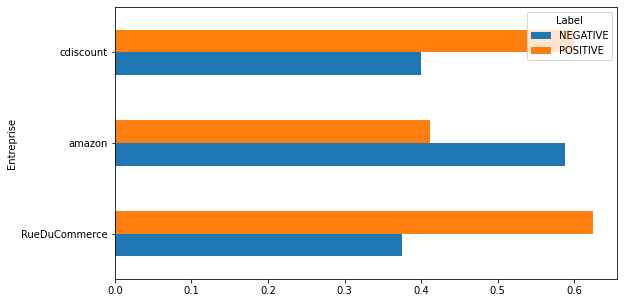

In [266]:
grp.plot.barh(figsize=(9,5))